## Dependencies 

In [2]:
import os 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import cv2
import random
from scipy import ndimage
from tqdm  import tqdm
import albumentations as A 

## Extract and Label data

In [49]:
def get_labels() -> list[dict]:
    furniture_path = './Furniture_Data'
    labels =  []
    for root, _, files in os.walk(furniture_path):
        for file in files:
            if file.endswith('.jpg'):
                
                path = os.path.join(root, file)
                dirs = path.split(os.path.sep)

                furniture = dirs[2][:-1] #Remove trailing `s` 
                style = dirs[3].lower() #lowercase

                label = {
                    'path': path,
                    'furniture': furniture,
                    'style': style
                }

                labels.append(label)

    return pd.DataFrame(labels)

df = get_labels()

In [7]:
df.head()

,path,furniture,style
0,./Furniture_Data/tables/Eclectic/4029eclectic-...,table,eclectic
1,./Furniture_Data/tables/Eclectic/3879eclectic-...,table,eclectic
2,./Furniture_Data/tables/Eclectic/4107eclectic-...,table,eclectic
3,./Furniture_Data/tables/Eclectic/3785eclectic-...,table,eclectic
4,./Furniture_Data/tables/Eclectic/3950eclectic-...,table,eclectic


## EDA 

The dataset sample isn't distributed evenly across all furniture

furniture
lamp       32401
chair      22053
table      19330
dresser     7870
bed         6578
sofa        4080
Name: count, dtype: int64

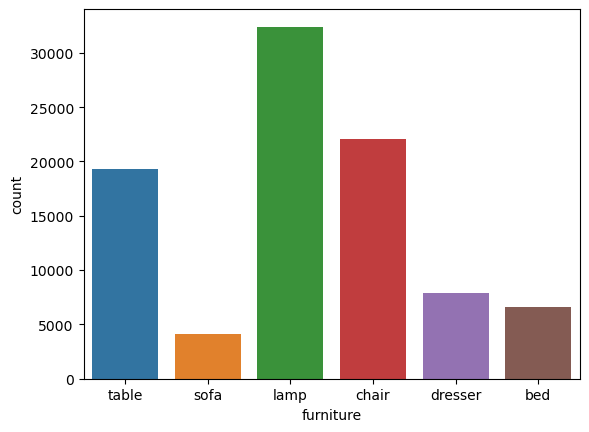

In [8]:
sns.countplot(data=df, x="furniture")

df['furniture'].value_counts()

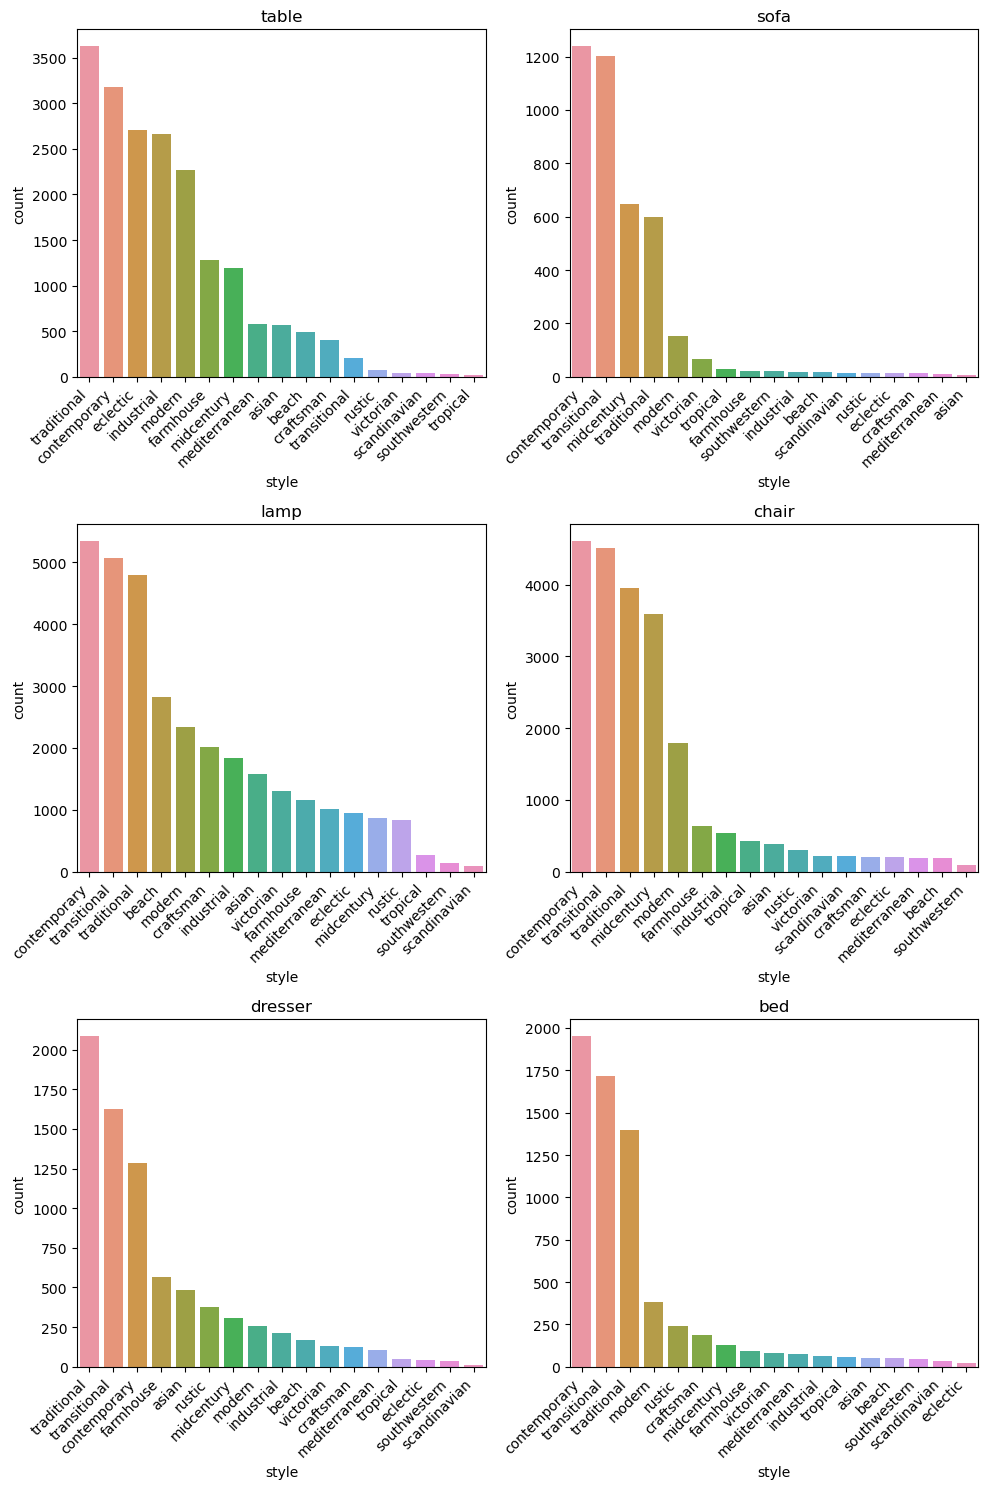

In [6]:
# Get unique furniture types
furniture_types = df['furniture'].unique()

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15), sharex=False)

# Plot each furniture type
for i, furniture_type in enumerate(furniture_types):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    data = df[df['furniture'] == furniture_type]
    sns.countplot(x='style', data=data, order=data['style'].value_counts().index, ax=ax)
    ax.set_title(furniture_type)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Show x-axis tick labels for each subplot
    ax.tick_params(axis='x', which='both', bottom=True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [73]:
# df['furniture'].value_counts().values
category = ['furniture','style']
df_audit = df[category].value_counts().reset_index()
df_audit

,furniture,style,count
0,lamp,contemporary,5343
1,lamp,transitional,5066
2,lamp,traditional,4789
3,chair,contemporary,4608
4,chair,transitional,4514
...,...,...,...
97,sofa,craftsman,13
98,sofa,eclectic,13
99,dresser,scandinavian,11
100,sofa,mediterranean,9


In [36]:
df_audit.pivot(index='style', columns='furniture', values='count')

furniture,bed,chair,dresser,lamp,sofa,table
style,,,,,,
asian,52,381,484,1572,7,573
beach,51,186,166,2820,17,494
contemporary,1953,4608,1284,5343,1240,3177
craftsman,188,210,128,2020,13,409
eclectic,22,201,41,942,13,2705
farmhouse,91,640,567,1154,21,1279
industrial,61,534,216,1837,17,2661
mediterranean,75,187,109,1012,9,582
midcentury,130,3585,307,874,647,1194


## Data Augmentation

Try to apply following data augmentation techniques 
- Flip
- Rotate
- Histogram Equalization

In [53]:
# Function for histogram equalization
def hist_equal(img):
    img_to_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_to_yuv[:, :, 0] = cv2.equalizeHist(img_to_yuv[:, :, 0])
    hist_equalization_result = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
    return hist_equalization_result

# Function for image zooming
def zoom_image(image, scale, center):
    
    height, width = image.shape[:2]
    new_height = int(height * scale)
    new_width = int(width * scale)

    zoomed_image = cv2.resize(image, (new_width, new_height))
    x = int(center[0] - width / 2)
    y = int(center[1] - width / 2)
    roi = zoomed_image[y : y + height, x : x + width]

    return roi

# # Function for image augmentation
# def image_augmentation(image):
#     flip_h = cv2.flip(image, 0) # Flip image horizontally

#     # Get image dimensions
#     height, width = flip_h.shape[:2]

#     # Define the zoom factor (e.g., zooming in by a factor of 1.5)
#     zoom_factor = 1.5

#     # Calculate the new dimensions after zooming
#     new_height = int(height * zoom_factor)
#     new_width = int(width * zoom_factor)

#     zoomed_image = cv2.resize(image, (new_width, new_height))
#     histogram = hist_equal(image)
#     adjusted = cv2.convertScaleAbs(histogram, alpha = 1.0, beta = 5) # Adjust image's contrast and brightness

#     return adjusted


# Function for image augmentation
def augment_image(image):
    transform = A.Compose([
    A.CLAHE(),
    A.RandomRotate90(),
    A.Transpose(),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
    A.Blur(blur_limit=3),
    A.OpticalDistortion(),
    A.GridDistortion(),
    A.HueSaturationValue(),
])
    augmented_image = transform(image=image)['image']
    return augmented_image

**Resampling Problem Brainstorming**
- Flowers: Only have 1 layer of category. Can easily resample by just calculating the difference between each category with the category max amount
   - Technique: Transform the curr scanned image until the current number of category matches the maximum amount
- Furniture: Have 2 layers of categories
  - Naive resampling: Can evenly distribute across furnitures, however styles distribution can be uneven 
  - More cater resampling techniques (Proposed)
    0. Copy curr image folders to `Transformed-Furnitures`
    1. Get the amount of the style of the furniture with maximum amount. Assign to `maximum_amount`
    2. (Optional) Remove that style of the furniture if's smaller than <threshold> (suggest 5% compared to max amount)
    3. Loop thru each image of the category and apply the transformation.
      3a. Increment the `current_amount` by 1
      3b. Saved the new image to corresponding category in `Transformed Furnitures`
    5. Break if `current_amount` doesn't match `maximum_amount`
    6. Continue until end of the loop. If the `current_amount` still doesn't match the `maximum_amount`, then repeat step 3,4 and 5.

### Copy raw images dir to transformed images dir

In [42]:
raw_furniture_path = './Furniture_Data'
transformed_furniture_path = './Transformed_Furniture_Data'

In [12]:
def copy_images_dir():
    # Terminal commands to remove the 'transformed-images' folder if it exists
    if not os.path.exists(transformed_furniture_path):        
        # Terminal command to copy images to the 'transformed-images' folder
        copy_command = f"cp -r {raw_furniture_path} {transformed_furniture_path}"
        os.system(copy_command)
        print("Copying completed successfully.")
        copy_images_dir()
    else:
        print("Folder already exist")

copy_images_dir()

Folder already exist


### Calculate Furniture Style's maximum amount

In [51]:
max_amount = df.groupby(['furniture', 'style']).size().max()
max_amount


5343

### Get combinations of furniture and style unique values 


In [38]:
category_combinations = df[['furniture', 'style']].drop_duplicates().to_records(index=False)
category_combinations[:5]

rec.array([('table', 'eclectic'), ('table', 'midcentury'),
           ('table', 'craftsman'), ('table', 'victorian'),
           ('table', 'transitional')],
          dtype=[('furniture', 'O'), ('style', 'O')])

### Transform

In [69]:
def transform(df: pd.DataFrame) -> pd.DataFrame:
    # Removed old transformed images before executing new ones
    clear_transformed_images()
    
    df_transform = None
    for furniture, style in tqdm(category_combinations):
        print(furniture, style)
        df_category = df[(df['furniture'] == furniture) & (df['style'] == style)]

        # Resize  first
        df_resized =  resize_image(df_category)
        
        # Random pick an image in transformed image, then perform aumgnetation
        df_augmented = advanced_transform(df_resized)

        # concat augmented and resized
        df_transform = df_augmented if df_transform is None else pd.concat([df_transform, df_augmented], ignore_index=True)

    
    return df_transform

def clear_transformed_images():
    # Clear images with pattern "resized" or "augmented"
    removed_augmented_command = "find . -type f -name '*-augmented*.jpg' -exec rm {} +"
    removed_resized_command = "find . -type f -name '*-resized*.jpg' -exec rm {} +"
    os.system(removed_augmented_command)
    os.system(removed_resized_command)
    print("Removed all transformed images with suffix -resized and -augmented")

def resize_image(df_category: pd.DataFrame) -> int:
    """
    Args:
    - df_category(pd.Dataframe)
    Return:
    - pd.Dataframe: New dataframe with initial images and resized images
    """
    current_amount = len(df_category)
    remainer_amount = max_amount - current_amount 
    print(current_amount, remainer_amount)
    resized_data = []
    
    for _, record in df_category[:remainer_amount].iterrows():
        # Read Image
        img_arr = cv2.imread(record['path'])
        
        # Resize
        resized_img_arr = cv2.resize(img_arr, (150, 150))
        
        # Generate a name: {current_name}-resized
        file_path, _ = os.path.splitext(record['path'])
        file_path = file_path.replace(raw_furniture_path, transformed_furniture_path)
        
        resized_path = f"{file_path}-resized.jpg"
        
        # Write output  and get path
        # print(f'Write resized image to disk {resized_path}')
        cv2.imwrite(resized_path, resized_img_arr)
        
        # Append new record to list
        resized_data.append((
            resized_path,
            record['furniture'],
            record['style']
        ))
    
    
    df_resized = pd.DataFrame(resized_data, columns=df_category.columns)
    return pd.concat([df_category, df_resized], ignore_index=True)

def advanced_transform(df_resized):
    current_amount = len(df_resized)
    augmented_data = []
    
    while current_amount < max_amount:
        # Pick random img file
        random_df_index = random.choice(df_resized.index.to_list())
        random_df_record = df_resized.iloc[random_df_index]
        
        random_img_file_path = random_df_record['path'] 
        
        #  Augment the img 
        random_img_arr = cv2.imread(random_img_file_path)
        augmented_img_arr = augment_image(random_img_arr)


        # Gen file path
        file_path, _ = os.path.splitext(random_img_file_path)
        augmented_img_file_path = f"{file_path}-augmented-{current_amount}.jpg"

        # Write augmented image to disk
        # print(f'Write augmeted image to disk {augmented_img_file_path}')
        cv2.imwrite(augmented_img_file_path, augmented_img_arr)
        
        # Store new data
        augmented_data.append((
            augmented_img_file_path,
            random_df_record['furniture'],
            random_df_record['style']
        ))
        
        current_amount += 1 
    
    print(current_amount, max_amount)

    
    df_augmented = pd.DataFrame(augmented_data, columns=df_resized.columns)
    return pd.concat([df_resized, df_augmented], ignore_index=True)
        

In [70]:
# Transform df
df_transformed = df.copy()
df_transformed['path'] = df_transformed['path'].str.replace('Furniture_Data','Transformed_Furniture_Data')
df_transformed = transform(df_transformed)

Removed all transformed images with suffix -resized and -augmented


  0%|                                                                                                | 0/102 [00:00<?, ?it/s]

table eclectic
410 4933


  1%|▊                                                                                       | 1/102 [00:23<39:15, 23.33s/it]

5343 5343
table midcentury
1194 4149


  2%|█▋                                                                                      | 2/102 [00:39<31:25, 18.86s/it]

5343 5343
table craftsman
409 4934


  3%|██▌                                                                                     | 3/102 [01:01<33:57, 20.58s/it]

5343 5343
table victorian
46 5297


  4%|███▍                                                                                    | 4/102 [01:27<36:49, 22.55s/it]

5343 5343
table transitional
207 5136


  5%|████▎                                                                                   | 5/102 [01:56<40:30, 25.06s/it]

5343 5343
table mediterranean
582 4761


  6%|█████▏                                                                                  | 6/102 [02:24<41:33, 25.97s/it]

5343 5343
table traditional
3629 1714


  7%|██████                                                                                  | 7/102 [02:29<30:16, 19.12s/it]

5343 5343
table industrial
2661 2682


  8%|██████▉                                                                                 | 8/102 [02:38<24:59, 15.95s/it]

5343 5343
table farmhouse
1279 4064


  9%|███████▊                                                                                | 9/102 [03:01<28:00, 18.07s/it]

5343 5343
table tropical
24 5319


 10%|████████▌                                                                              | 10/102 [03:33<34:20, 22.40s/it]

5343 5343
table southwestern
27 5316


 11%|█████████▍                                                                             | 11/102 [04:03<37:30, 24.73s/it]

5343 5343
table beach
494 4849


 12%|██████████▏                                                                            | 12/102 [04:26<36:24, 24.27s/it]

5343 5343
table modern
2272 3071


 13%|███████████                                                                            | 13/102 [04:36<29:16, 19.73s/it]

5343 5343
table contemporary
3177 2166


 14%|███████████▉                                                                           | 14/102 [04:41<22:28, 15.32s/it]

5343 5343
table rustic
71 5272


 15%|████████████▊                                                                          | 15/102 [05:07<26:50, 18.51s/it]

5343 5343
table scandinavian
45 5298


 16%|█████████████▋                                                                         | 16/102 [05:33<29:51, 20.84s/it]

5343 5343
table asian
573 4770


 17%|██████████████▌                                                                        | 17/102 [05:56<30:20, 21.42s/it]

5343 5343
sofa eclectic
13 5330


 18%|███████████████▎                                                                       | 18/102 [06:23<32:21, 23.11s/it]

5343 5343
sofa midcentury
647 4696


 19%|████████████████▏                                                                      | 19/102 [06:46<31:53, 23.06s/it]

5343 5343
sofa craftsman
13 5330


 20%|█████████████████                                                                      | 20/102 [07:16<34:39, 25.36s/it]

5343 5343
sofa victorian
66 5277


 21%|█████████████████▉                                                                     | 21/102 [07:46<35:59, 26.66s/it]

5343 5343
sofa transitional
1201 4142


 22%|██████████████████▊                                                                    | 22/102 [08:09<34:10, 25.64s/it]

5343 5343
sofa mediterranean
9 5334


 23%|███████████████████▌                                                                   | 23/102 [08:39<35:31, 26.98s/it]

5343 5343
sofa traditional
599 4744


 24%|████████████████████▍                                                                  | 24/102 [09:04<34:10, 26.29s/it]

5343 5343
sofa industrial
17 5326


 25%|█████████████████████▎                                                                 | 25/102 [09:31<34:02, 26.53s/it]

5343 5343
sofa farmhouse
21 5322


 25%|██████████████████████▏                                                                | 26/102 [10:01<34:49, 27.49s/it]

5343 5343
sofa tropical
28 5315


 26%|███████████████████████                                                                | 27/102 [10:30<34:54, 27.93s/it]

5343 5343
sofa southwestern
20 5323


 27%|███████████████████████▉                                                               | 28/102 [11:00<35:18, 28.63s/it]

5343 5343
sofa beach
17 5326


 28%|████████████████████████▋                                                              | 29/102 [11:29<35:01, 28.79s/it]

5343 5343
sofa modern
152 5191


 29%|█████████████████████████▌                                                             | 30/102 [11:58<34:40, 28.90s/it]

5343 5343
sofa contemporary
1240 4103


 30%|██████████████████████████▍                                                            | 31/102 [12:17<30:26, 25.72s/it]

5343 5343
sofa rustic
15 5328


 31%|███████████████████████████▎                                                           | 32/102 [12:45<30:51, 26.45s/it]

5343 5343
sofa scandinavian
15 5328


 32%|████████████████████████████▏                                                          | 33/102 [13:13<31:08, 27.09s/it]

5343 5343
sofa asian
7 5336


 33%|█████████████████████████████                                                          | 34/102 [13:41<30:47, 27.16s/it]

5343 5343
lamp eclectic
942 4401


 34%|█████████████████████████████▊                                                         | 35/102 [14:02<28:16, 25.32s/it]

5343 5343
lamp midcentury
874 4469


 35%|██████████████████████████████▋                                                        | 36/102 [14:22<26:06, 23.73s/it]

5343 5343
lamp craftsman
2020 3323


 36%|███████████████████████████████▌                                                       | 37/102 [14:34<21:53, 20.20s/it]

5343 5343
lamp victorian
1302 4041


 37%|████████████████████████████████▍                                                      | 38/102 [14:50<20:19, 19.06s/it]

5343 5343
lamp transitional
5066 277


 38%|█████████████████████████████████▎                                                     | 39/102 [14:51<14:15, 13.58s/it]

5343 5343
lamp mediterranean
1012 4331


 39%|██████████████████████████████████                                                     | 40/102 [15:11<15:57, 15.45s/it]

5343 5343
lamp traditional
4789 554


 40%|██████████████████████████████████▉                                                    | 41/102 [15:13<11:37, 11.44s/it]

5343 5343
lamp industrial
1837 3506


 41%|███████████████████████████████████▊                                                   | 42/102 [15:26<12:02, 12.04s/it]

5343 5343
lamp farmhouse
1154 4189


 42%|████████████████████████████████████▋                                                  | 43/102 [15:46<14:13, 14.46s/it]

5343 5343
lamp tropical
271 5072


 43%|█████████████████████████████████████▌                                                 | 44/102 [16:14<17:44, 18.36s/it]

5343 5343
lamp southwestern
138 5205


 44%|██████████████████████████████████████▍                                                | 45/102 [16:40<19:31, 20.55s/it]

5343 5343
lamp beach
2820 2523


 45%|███████████████████████████████████████▏                                               | 46/102 [16:46<15:15, 16.35s/it]

5343 5343
lamp modern
2335 3008


 46%|████████████████████████████████████████                                               | 47/102 [16:55<13:03, 14.25s/it]

5343 5343
lamp contemporary
5343 0
5343 5343
lamp rustic
832 4511


 48%|█████████████████████████████████████████▊                                             | 49/102 [17:17<11:11, 12.66s/it]

5343 5343
lamp scandinavian
94 5249


 49%|██████████████████████████████████████████▋                                            | 50/102 [17:40<13:14, 15.28s/it]

5343 5343
lamp asian
1572 3771


 50%|███████████████████████████████████████████▌                                           | 51/102 [17:54<12:42, 14.95s/it]

5343 5343
chair eclectic
201 5142


 51%|████████████████████████████████████████████▎                                          | 52/102 [18:18<14:30, 17.42s/it]

5343 5343
chair midcentury
3585 1758


 52%|█████████████████████████████████████████████▏                                         | 53/102 [18:23<11:17, 13.83s/it]

5343 5343
chair craftsman
210 5133


 53%|██████████████████████████████████████████████                                         | 54/102 [18:51<14:13, 17.77s/it]

5343 5343
chair victorian
218 5125


 54%|██████████████████████████████████████████████▉                                        | 55/102 [19:16<15:35, 19.90s/it]

5343 5343
chair transitional
4514 829


 55%|███████████████████████████████████████████████▊                                       | 56/102 [19:17<11:12, 14.62s/it]

5343 5343
chair mediterranean
187 5156


 56%|████████████████████████████████████████████████▌                                      | 57/102 [19:42<13:13, 17.63s/it]

5343 5343
chair traditional
3956 1387


 57%|█████████████████████████████████████████████████▍                                     | 58/102 [19:46<09:47, 13.36s/it]

5343 5343
chair industrial
534 4809


 58%|██████████████████████████████████████████████████▎                                    | 59/102 [20:08<11:31, 16.09s/it]

5343 5343
chair farmhouse
640 4703


 59%|███████████████████████████████████████████████████▏                                   | 60/102 [20:29<12:16, 17.52s/it]

5343 5343
chair tropical
430 4913


 60%|████████████████████████████████████████████████████                                   | 61/102 [20:51<12:51, 18.83s/it]

5343 5343
chair southwestern
95 5248


 61%|████████████████████████████████████████████████████▉                                  | 62/102 [21:16<13:54, 20.86s/it]

5343 5343
chair beach
186 5157


 62%|█████████████████████████████████████████████████████▋                                 | 63/102 [21:39<13:50, 21.29s/it]

5343 5343
chair modern
1788 3555


 63%|██████████████████████████████████████████████████████▌                                | 64/102 [21:51<11:44, 18.53s/it]

5343 5343
chair contemporary
4608 735


 64%|███████████████████████████████████████████████████████▍                               | 65/102 [21:52<08:17, 13.46s/it]

5343 5343
chair rustic
304 5039


 65%|████████████████████████████████████████████████████████▎                              | 66/102 [22:15<09:43, 16.20s/it]

5343 5343
chair scandinavian
216 5127


 66%|█████████████████████████████████████████████████████████▏                             | 67/102 [22:37<10:25, 17.87s/it]

5343 5343
chair asian
381 4962


 67%|██████████████████████████████████████████████████████████                             | 68/102 [22:59<10:55, 19.28s/it]

5343 5343
dresser eclectic
41 5302


 68%|██████████████████████████████████████████████████████████▊                            | 69/102 [23:26<11:48, 21.48s/it]

5343 5343
dresser midcentury
307 5036


 69%|███████████████████████████████████████████████████████████▋                           | 70/102 [23:50<11:46, 22.09s/it]

5343 5343
dresser craftsman
128 5215


 70%|████████████████████████████████████████████████████████████▌                          | 71/102 [24:15<11:56, 23.10s/it]

5343 5343
dresser victorian
133 5210


 71%|█████████████████████████████████████████████████████████████▍                         | 72/102 [24:39<11:44, 23.49s/it]

5343 5343
dresser transitional
1622 3721


 72%|██████████████████████████████████████████████████████████████▎                        | 73/102 [24:52<09:48, 20.30s/it]

5343 5343
dresser mediterranean
109 5234


 73%|███████████████████████████████████████████████████████████████                        | 74/102 [25:17<10:09, 21.75s/it]

5343 5343
dresser traditional
2086 3257


 74%|███████████████████████████████████████████████████████████████▉                       | 75/102 [25:28<08:16, 18.39s/it]

5343 5343
dresser industrial
216 5127


 75%|████████████████████████████████████████████████████████████████▊                      | 76/102 [25:51<08:36, 19.85s/it]

5343 5343
dresser farmhouse
567 4776


 75%|█████████████████████████████████████████████████████████████████▋                     | 77/102 [26:13<08:29, 20.38s/it]

5343 5343
dresser tropical
47 5296


 76%|██████████████████████████████████████████████████████████████████▌                    | 78/102 [26:38<08:45, 21.88s/it]

5343 5343
dresser southwestern
35 5308


 77%|███████████████████████████████████████████████████████████████████▍                   | 79/102 [27:04<08:51, 23.09s/it]

5343 5343
dresser beach
166 5177


 78%|████████████████████████████████████████████████████████████████████▏                  | 80/102 [27:28<08:30, 23.21s/it]

5343 5343
dresser modern
256 5087


 79%|█████████████████████████████████████████████████████████████████████                  | 81/102 [27:51<08:11, 23.39s/it]

5343 5343
dresser contemporary
1284 4059


 80%|█████████████████████████████████████████████████████████████████████▉                 | 82/102 [28:08<07:04, 21.25s/it]

5343 5343
dresser rustic
378 4965
5343 5343


 81%|██████████████████████████████████████████████████████████████████████▊                | 83/102 [28:35<07:20, 23.20s/it]

dresser scandinavian
11 5332


 82%|███████████████████████████████████████████████████████████████████████▋               | 84/102 [29:00<07:05, 23.62s/it]

5343 5343
dresser asian
484 4859


 83%|████████████████████████████████████████████████████████████████████████▌              | 85/102 [29:23<06:39, 23.52s/it]

5343 5343
bed eclectic
22 5321


 84%|█████████████████████████████████████████████████████████████████████████▎             | 86/102 [29:41<05:46, 21.64s/it]

5343 5343
bed midcentury
130 5213


 85%|██████████████████████████████████████████████████████████████████████████▏            | 87/102 [29:57<05:00, 20.01s/it]

5343 5343
bed craftsman
188 5155


 86%|███████████████████████████████████████████████████████████████████████████            | 88/102 [30:13<04:23, 18.79s/it]

5343 5343
bed victorian
83 5260


 87%|███████████████████████████████████████████████████████████████████████████▉           | 89/102 [30:28<03:50, 17.71s/it]

5343 5343
bed transitional
1719 3624


 88%|████████████████████████████████████████████████████████████████████████████▊          | 90/102 [30:36<02:58, 14.89s/it]

5343 5343
bed mediterranean
75 5268


 89%|█████████████████████████████████████████████████████████████████████████████▌         | 91/102 [30:54<02:52, 15.71s/it]

5343 5343
bed traditional
1397 3946


 90%|██████████████████████████████████████████████████████████████████████████████▍        | 92/102 [31:05<02:23, 14.34s/it]

5343 5343
bed industrial
61 5282


 91%|███████████████████████████████████████████████████████████████████████████████▎       | 93/102 [31:21<02:12, 14.70s/it]

5343 5343
bed farmhouse
91 5252


 92%|████████████████████████████████████████████████████████████████████████████████▏      | 94/102 [31:36<01:59, 14.98s/it]

5343 5343
bed tropical
55 5288


 93%|█████████████████████████████████████████████████████████████████████████████████      | 95/102 [31:53<01:48, 15.54s/it]

5343 5343
bed southwestern
49 5294


 94%|█████████████████████████████████████████████████████████████████████████████████▉     | 96/102 [32:10<01:35, 15.91s/it]

5343 5343
bed beach
51 5292


 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 97/102 [32:25<01:19, 15.80s/it]

5343 5343
bed modern
380 4963


 96%|███████████████████████████████████████████████████████████████████████████████████▌   | 98/102 [32:40<01:01, 15.40s/it]

5343 5343
bed contemporary
1953 3390


 97%|████████████████████████████████████████████████████████████████████████████████████▍  | 99/102 [32:48<00:39, 13.14s/it]

5343 5343
bed rustic
239 5104


 98%|████████████████████████████████████████████████████████████████████████████████████▎ | 100/102 [33:03<00:27, 13.67s/it]

5343 5343
bed scandinavian
33 5310


 99%|█████████████████████████████████████████████████████████████████████████████████████▏| 101/102 [33:17<00:13, 13.94s/it]

5343 5343
bed asian
52 5291


100%|██████████████████████████████████████████████████████████████████████████████████████| 102/102 [33:33<00:00, 19.74s/it]

5343 5343


In [71]:
df_transformed.furniture.value_counts()

furniture
table      90831
sofa       90831
lamp       90831
chair      90831
dresser    90831
bed        90831
Name: count, dtype: int64

In [75]:
df_transformed.shape

(544986, 3)

In [74]:
df_transformed[category].value_counts().reset_index().pivot(index='style', columns='furniture', values='count')

furniture,bed,chair,dresser,lamp,sofa,table
style,,,,,,
asian,5343,5343,5343,5343,5343,5343
beach,5343,5343,5343,5343,5343,5343
contemporary,5343,5343,5343,5343,5343,5343
craftsman,5343,5343,5343,5343,5343,5343
eclectic,5343,5343,5343,5343,5343,5343
farmhouse,5343,5343,5343,5343,5343,5343
industrial,5343,5343,5343,5343,5343,5343
mediterranean,5343,5343,5343,5343,5343,5343
midcentury,5343,5343,5343,5343,5343,5343


## Post-execution

Save dataset 

In [76]:
# Define the directory to save the model
def save_dataset(df: pd.DataFrame, data_file_name: str) -> None:
    data_dir = "./data"
    data_file_path = os.path.join(data_dir, data_file_name)
    
    # Check if the directory exists, and if not, create it
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    df.to_parquet(data_file_path, index=False, engine='pyarrow')
    print(f"Saved DataFrame to {data_file_path}")

data_transformed_file_name = "transforms.parquet"
data_raws_file_name = "raws.parquet"

save_dataset(df_transformed, data_transformed_file_name)
save_dataset(df, data_raws_file_name)

Saved DataFrame to ./data/transforms.parquet
Saved DataFrame to ./data/raws.parquet
